<a href="https://colab.research.google.com/github/SantoshSrinivas79/AI-ART/blob/main/Plant_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Generator

This is the code I used to generate the alien plants in this image: https://www.easyzoom.com/imageaccess/2128f27845ed4921b3143004dc550c3e

Based on work by @RiversHaveWings and many others. 

Feel free to use as you like. If possible credit me @johnowhitakerA - tag me on twitter with your art, I love seeing what others make :)

More info on this space in general: https://www.youtube.com/watch?v=VcwpVcbsnTk 

# Setup 

Run once to install libraries etc:

In [ ]:
import requests

print('Downloading model weights')
url = 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1'
r = requests.get(url, allow_redirects=True)
open('vqgan_imagenet_f16_16384.yaml', 'wb').write(r.content)
url = 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1'
r = requests.get(url, allow_redirects=True)
open('vqgan_imagenet_f16_16384.ckpt', 'wb').write(r.content)

print("Downloading CLIP...")
!git clone https://github.com/openai/CLIP                
 
print("Installing some useful libraries.")
!git clone https://github.com/CompVis/taming-transformers
!pip install ftfy regex tqdm omegaconf pytorch-lightning 
!pip install kornia                                       
!pip install einops                                      
!pip install stegano                                     
!apt install exempi                         
!pip install python-xmp-toolkit                           
!pip install imgtag                                       
!pip install pillow==7.1.2                                
!pip install transformers                                 
!pip install imageio-ffmpeg 
!mkdir steps
print("Done")

Cloning into 'CLIP'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 133 (delta 18), reused 26 (delta 13), pack-reused 91
Receiving objects: 100% (133/133), 8.82 MiB | 31.79 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Installing some useful libraries.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 779, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 779 (delta 0), reused 14 (delta 0), pack-reused 756
Receiving objects: 100% (779/779), 202.24 MiB | 25.96 MiB/s, done.
Resolving deltas: 100% (188/188), done.
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 74 kB 4.3 MB/s 
     |████████████████████████████████| 918 kB 62.1 MB/s 
     |████████████████████████████████| 636 kB 64.8 MB/s 
     |████████████████████████████████| 112 kB 51.5 MB/s 
     |

     |████████████████████████████████| 303 kB 8.3 MB/s 
     |████████████████████████████████| 301 kB 9.0 MB/s 
     |████████████████████████████████| 3.0 MB 58.7 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libexempi3
The following NEW packages will be installed:
  exempi libexempi3
0 upgraded, 2 newly installed, 0 to remove and 40 not upgraded.
Need to get 553 kB of archives.
After this operation, 1,750 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libexempi3 amd64 2.4.5-2 [543 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 exempi amd64 2.4.5-2 [10.0 kB]
Fetched 553 kB in 1s (419 kB/s)
Selecting previously unselected package libexempi3:amd64.
(Reading database ... 148486 files and directories currently installed.)
Preparing to unpack .../libexempi3_2.4.5-2_amd64.deb ...
Unpacking libexempi3:amd64 (2.4.5-2) ...
Selecting previously unsele

     |████████████████████████████████| 2.6 MB 9.0 MB/s 
     |████████████████████████████████| 3.3 MB 58.1 MB/s 
     |████████████████████████████████| 895 kB 62.2 MB/s 
     |████████████████████████████████| 26.9 MB 1.2 MB/s 
Done


# Imports and useful functions

Run on restarts

In [ ]:
#@title Imports
import argparse
import math
from pathlib import Path
import sys
 
sys.path.append('./taming-transformers')
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
 
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    # metadatos 
from libxmp import *         # metadatos
import libxmp                # metadatos
from stegano import lsb
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True
 
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

# Generating Prompts

Get creative here - try different styles, extra keywords (see https://imgur.com/a/SnSIQRu for ideas) and different descriptions. Good luck :)

In [ ]:
import random
def get_prompt():
    s = 'A ' + random.choice(['biological illustration', 'nature journal watercolor'])
    s += ' of an ' +random.choice(['alien', 'unusual', 'interesting']) +' fruit in cross-section, watercolor'
    return s
get_prompt()

'A biological illustration of an unusual fruit in cross-section, watercolor'

# Creating the images

Run to generate n_images images (they'll go into a folder called 'plants').

Using device: cuda:0
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 102kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 196MiB/s]


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/kornia/utils/helpers.py:96: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  out1, out2 = torch.solve(input.to(dtype), A.to(dtype))


i: 250, loss: 0.581792, losses: 0.581792


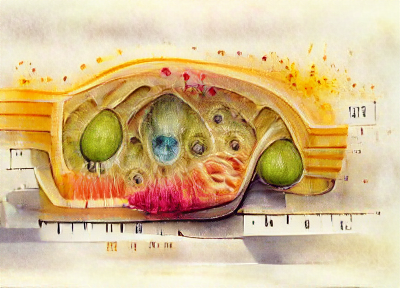

0it [00:00, ?it/s]

i: 250, loss: 0.584678, losses: 0.584678


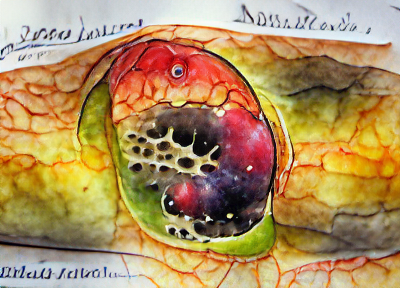

0it [00:00, ?it/s]

i: 250, loss: 0.569522, losses: 0.569522


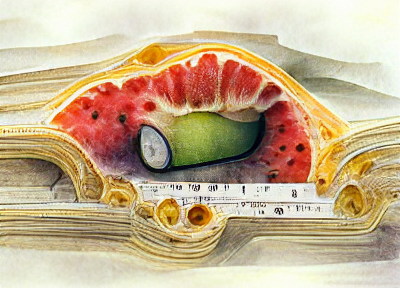

0it [00:00, ?it/s]

i: 250, loss: 0.598623, losses: 0.598623


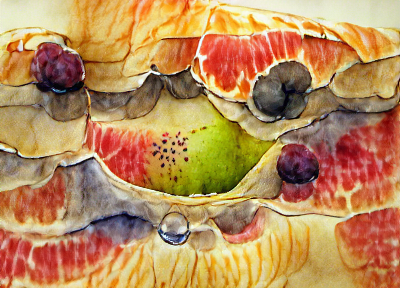

0it [00:00, ?it/s]

i: 250, loss: 0.579665, losses: 0.579665


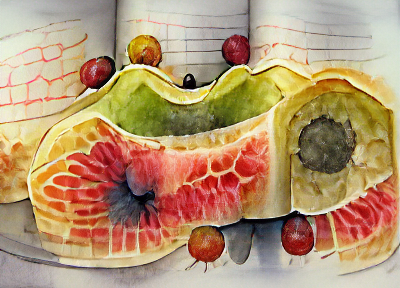

0it [00:00, ?it/s]

i: 250, loss: 0.590899, losses: 0.590899


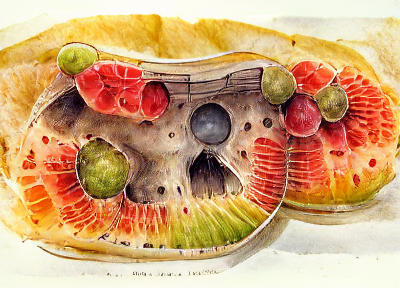

0it [00:00, ?it/s]

i: 250, loss: 0.582121, losses: 0.582121


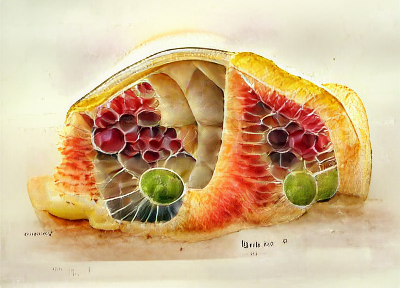

0it [00:00, ?it/s]

In [ ]:
#Atitle Generation
n_images = 20 #@param
width = 400 #@param
height = 300 #@param
step_size = 0.1
cutn = 16
cut_pow = 1.
max_iter = 250#@param
save_every = 250
init_im = 'None' 

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Load models
model = load_vqgan_model('vqgan_imagenet_f16_16384.yaml', 'vqgan_imagenet_f16_16384.ckpt').to(device)    
# model = load_vqgan_model('wikiart_f16_16384.yaml', 'wikiart_f16_16384.ckpt').to(device)

perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)

# Setup ??
cut_size = perceptor.visual.input_resolution
e_dim = model.quantize.e_dim
f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, cutn, cut_pow=cut_pow)
n_toks = model.quantize.n_e
toksX, toksY = width // f, height // f
sideX, sideY = toksX * f, toksY * f
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

!mkdir -p plants

for pnum in range(n_images):
    
    p = get_prompt()
    

    if init_im != 'None':
      pil_image = Image.open(init_im).convert('RGB')
      pil_image = pil_image.resize((width, height), Image.LANCZOS)
      z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)
    else:
      one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
      z = one_hot @ model.quantize.embedding.weight
      z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)

    z_orig = z.clone()
    z.requires_grad_(True)
    opt = optim.Adam([z], lr=step_size)

    # Embed text into prompts
    pMs = []
    txt, weight, stop = parse_prompt(p)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))


    def synth(z):
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
        return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                     std=[0.26862954, 0.26130258, 0.27577711])

    @torch.no_grad()
    def checkin(i, losses):
        losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
        tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
        out = synth(z)
        TF.to_pil_image(out[0].cpu()).save('progress.png')
        display.display(display.Image('progress.png'))

    def ascend_txt():
        global i

        # Get im and embed
        out = synth(z)
        iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

        # Calculate loss(es)
        result = []
        for prompt in pMs:
            result.append(prompt(iii))

        # Store im
        if i % save_every == 0 and i > 1:
          out = synth(z)
          img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
          img = np.transpose(img, (1, 2, 0))
          filename = f"plants/plant{pnum}_{p}_{int(i/save_every):04}.png"
          imageio.imwrite(filename, np.array(img))

        return result

    def train(i):
        opt.zero_grad()
        lossAll = ascend_txt()
        if i % 250 == 0 and i > 0:
            checkin(i, lossAll)
        loss = sum(lossAll)
        loss.backward()
        opt.step()
        with torch.no_grad():
            z.copy_(z.maximum(z_min).minimum(z_max))

    i = 0
    try:
        with tqdm() as pbar:
            while True:
                train(i)
                if i == max_iter:
                    break
                i += 1
                pbar.update()
    except KeyboardInterrupt:
        pass

# Making a collage

Using `montage` from imagemagick. You can download the final result via the files pane on the left.

In [ ]:
!montage -density 300 -tile 5x0 -geometry +5+5 -border 10 plants/*.png collage.jpeg

# Final Thoughts

I threw this notebook together since someone on [HN](https://news.ycombinator.com/item?id=28286199) asked about it. Please excuse the slightly messy code :) No warranty yadda yadda.

Things like this really excite me - when combined with a bit of human input for picking the best results, manually tweaking images, adding story and getting creative, they allow for all kinds of artistic exploration and expression. The future is going to be really cool!

I play with stuff like this pretty much full-time - feel free to check out my twitter (@johnowhitaker or @johnowhitakerA for more art stuff) to see what else I'm working on, and do reach out with any questions or thoughts.